### Struture of notebook


1.  **Dependencies setup** : pip install required dependencies
2.  **Utility functions**
3.  **Graphs**
    * Part 1 of problem statement, to define own graphs
4.  **Maximal Independent Set Cost Function**
5.  **Solve using Gate-based QAOA with VQE**
    * Part 2a of problem statement
6.  **Solving using Quantum Adiabatic QAOA with Rydberg Atoms**
    * Part 2b of problem statement
7.  **Analysis**
    * Part 3 of problem statement

P.S. View notebook in [google colab](https://colab.research.google.com/drive/1tGzSP6oXEXlQQGpwT7Uud-3qBSilzcGj?usp=sharing), it looks better ;)



### Dependencies setup

In [1]:
!pip install qiskit --quiet
!pip install qiskit-ibm-runtime --quiet
!pip install qiskit[visualization] -quiet
!pip install networkx --quiet
!pip install qiskit-optimization --quiet
!pip install pulser --quiet


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -u


### Utility functions

In [2]:
import matplotlib.pyplot as plt

def draw_graph(graph, maximal_independent_set):
  if len(maximal_independent_set) <= 1:
    print(f"Cyclic graph with {len(graph.nodes)} nodes, has no maximal independent set" )
    return

  plt.figure(figsize=(4, 4))

  pos = nx.spring_layout(graph)
  nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=800, font_size=12)

  nx.draw_networkx_nodes(graph, pos, nodelist=maximal_independent_set, node_color='red', node_size=800)

  plt.title("Graph with Maximal independent set marked")
  plt.show()

In [3]:
def is_maximal_independent_set(bit_string):
  arr = [int(bit) for bit in bit_string]
  length = len(arr)
  num_ones = sum(arr)

  if num_ones != length // 2 or num_ones == 1:
    return False

  for i in range(length):
    next = (i+1) % length
    if arr[i] == 1 and arr[next] == 1:
        return False

  return True

def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))

    mark_red = [outcome for outcome in C.keys() if is_maximal_independent_set(outcome)]
    color_dict = {key: "r" if key in mark_red else "g" for key in C}

    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

### Graphs

Cyclic graphs serve as a fundamental tool for analyzing the maximal independent set problem.

Specifically, a cyclic graph with three nodes is unique in that it lacks a maximal independent set, whereas all other cyclic graphs possess a maximal independent set.

In [4]:
import networkx as nx

G3 = nx.cycle_graph(3)
draw_graph(G3,[]) # No solution possible

Cyclic graph with 3 nodes, has no maximal independent set


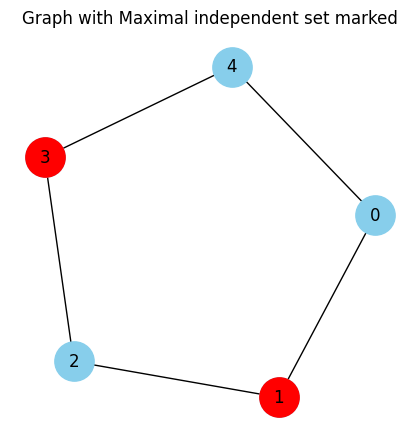

In [5]:
G5 = nx.cycle_graph(5)
draw_graph(G5,[1,3])

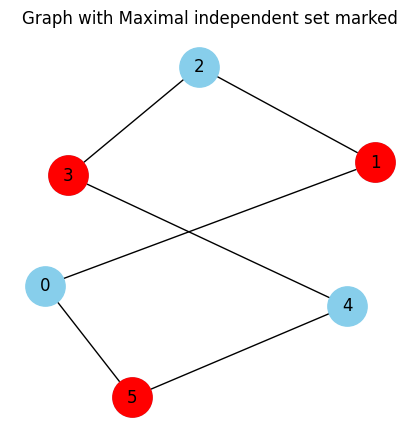

In [6]:
G6 = nx.cycle_graph(6)
draw_graph(G6,[1,3,5])

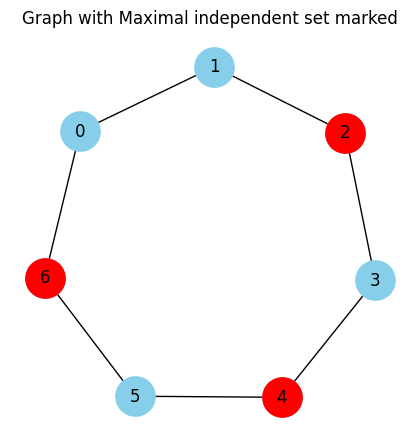

In [7]:
G7 = nx.cycle_graph(7)
draw_graph(G7,[2,4,6])

### Maximal Independent Set Cost Function

For the maximal independent set problem, the Quadratic Unconstrained Binary Optimization (QUBO) can be formulated as:

$$
C(x) = - \sum_{v \in V} x_v + 2\sum_{(u, v) \in E}x_u \cdot x_v
$$

- The first term maximizes the number of vertices in the set.
- The second term penalizes for choosing vertices that have an edge.
- Here, $x$ is a binary string where:
  - $x_i=1$ represents the $i$th node being in the set.
  - $x_i=0$ represents the $i$th node not being in the set.



In [8]:
from qiskit_optimization.problems import QuadraticProgram

def maximal_independent_set_qubo(graph):
    qp = QuadraticProgram(name= "MIS")

    # Define binary variables for each node
    for node in graph.nodes():
        qp.binary_var(name=f'x_{node}')

    # Add objective function: maximize the number of nodes in the independent set
    linear = { f'x_{node}': -1 for node in graph.nodes()}
    quadratic = {(f'x_{i}',f'x_{j}') : 2 for i,j in graph.edges()}
    qp.minimize(linear = linear, quadratic= quadratic)

    return qp

In [9]:
test = maximal_independent_set_qubo(G3)
print(test.prettyprint())

Problem name: MIS

Minimize
  2*x_0*x_1 + 2*x_0*x_2 + 2*x_1*x_2 - x_0 - x_1 - x_2

Subject to
  No constraints

  Binary variables (3)
    x_0 x_1 x_2



### Solve using Gate-based QAOA with VQE

The steps are as follows:

1. **Encode the QUBO into a Hamiltonian**
   - Convert the Quadratic Unconstrained Binary Optimization (QUBO) problem into a Hamiltonian.

2. **Utilize VQE Circuits to Find the Ground State**
   - Employ Variational Quantum Eigensolver (VQE) circuits.
   - Classical optimization techniques are used to adjust the parameters of the VQE circuit to minimize the expectation value of the Hamiltonian.

The below section shows the training curve with a reducing cost function. It also shows graph with their maximal independent set


In [10]:
from qiskit.circuit.library import TwoLocal
from qiskit_algorithms import SamplingVQE
from qiskit_algorithms.optimizers import SPSA
from qiskit.primitives import Sampler
from qiskit_optimization.applications.optimization_application import OptimizationApplication

import numpy as np

def find_maximal_independet_set(eigenstate):
  sample = OptimizationApplication.sample_most_likely(eigenstate)
  nodes = [i for i,chosen in enumerate(sample) if chosen == 1]
  return nodes

def print_stats(result):
  print("------- Stats ---------")
  print(f"Optimizing time : {result.optimizer_time:.3f}s")
  print(f"Cost function evaluations : {result.cost_function_evals}")

  eigenstate = result.eigenstate
  probability = max(result.eigenstate.values())
  print(f"Probability of best outcome :{probability}")
  print("-----------------------")

def plot_evaluations(eval_counts, eval_values):
  plt.figure(figsize=(8, 4))
  plt.plot(eval_counts, np.real(eval_values), marker='o', linestyle='-')
  plt.xlabel('Iteration')
  plt.ylabel('C(x)')
  plt.title('Cost vs iteration')
  plt.show()

def solve(qubo):
  qubitOp, offset = qubo.to_ising()
  optimizer = SPSA(maxiter=300)
  ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")

  eval_values = []
  eval_counts = []
  def callback(eval_count, parameters, mean, std):
      eval_values.append(mean)
      eval_counts.append(eval_count)

  vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer, callback=callback)

  result = vqe.compute_minimum_eigenvalue(qubitOp)
  plot_evaluations(eval_counts, eval_values)
  print_stats(result)

  return result

In [11]:
def mis_vqe(graph):
  qubo = maximal_independent_set_qubo(graph)
  result = solve(qubo)
  maximal_independent_set = find_maximal_independet_set(result.eigenstate)
  draw_graph(graph, maximal_independent_set)

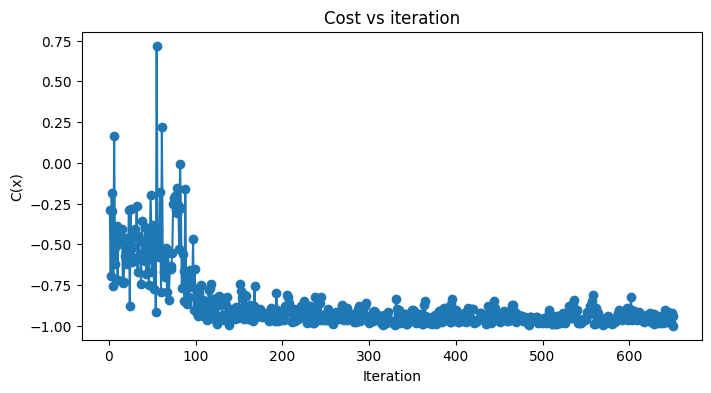

------- Stats ---------
Optimizing time : 4.064s
Cost function evaluations : 600
Probability of best outcome :0.6657448734322826
-----------------------
Cyclic graph with 3 nodes, has no maximal independent set


In [12]:
mis_vqe(G3)

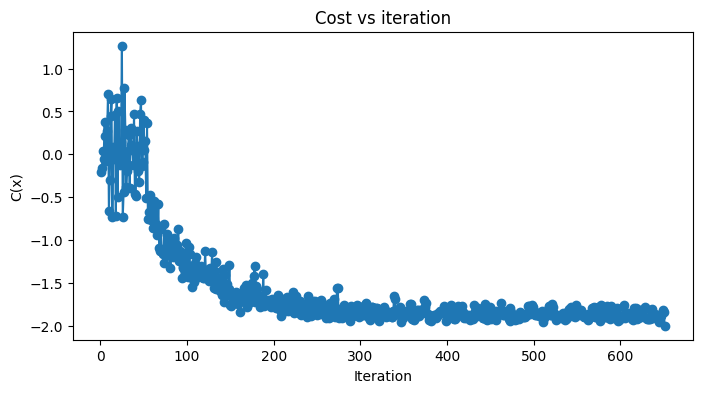

------- Stats ---------
Optimizing time : 8.694s
Cost function evaluations : 600
Probability of best outcome :0.4380360824365604
-----------------------


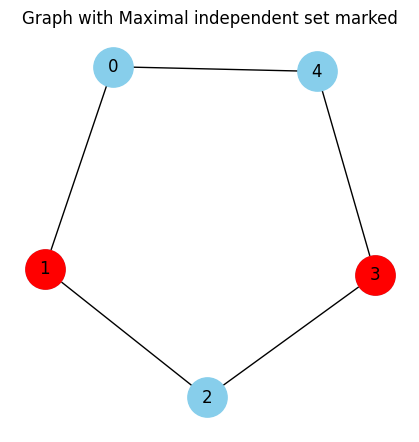

In [13]:
mis_vqe(G5)

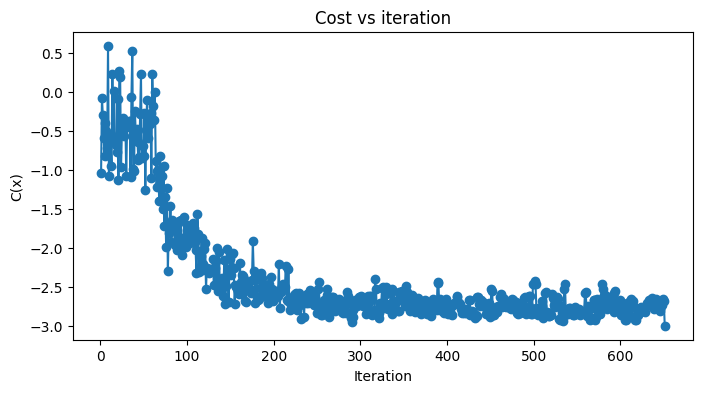

------- Stats ---------
Optimizing time : 16.929s
Cost function evaluations : 600
Probability of best outcome :0.9962737344217693
-----------------------


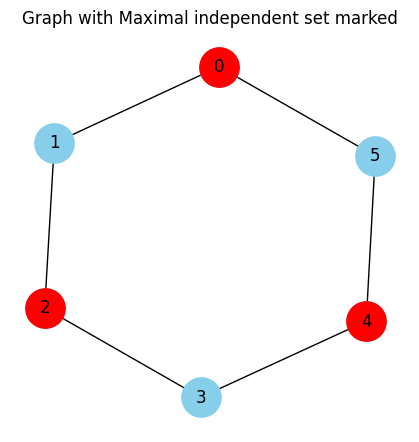

In [14]:
mis_vqe(G6)

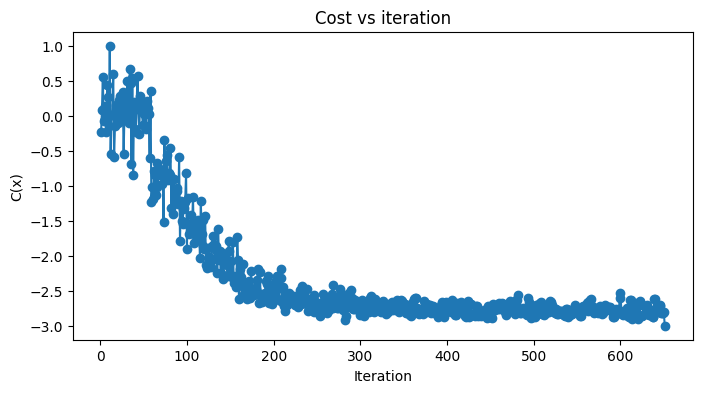

------- Stats ---------
Optimizing time : 8.108s
Cost function evaluations : 600
Probability of best outcome :0.5134109943981802
-----------------------


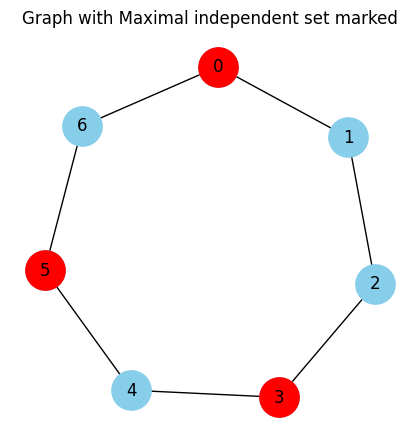

In [15]:
mis_vqe(G7)

### Solving using Quantum Adiabatic QAOA with Rydberg Atoms

The steps are as follows:

1. **Encode the QUBO into a Hamiltonian**
   - Utilize Rydberg atoms, which exhibit a unique behavior: when two atoms are closer than the "Rydberg radius," both cannot be in the excited Rydberg state simultaneously.
   - In our graph, if two nodes are connected by an edge, they should be within the Rydberg radius; otherwise, they must be farther apart.
   - Finding the ground state of the Hamiltonian for such an arrangement of atoms will solve the Maximum Independent Set (MIS) problem.

2. **Use Quantum Adiabatic Algorithm to Find the Ground State of the Hamiltonian**
   - Gradually change the system's Hamiltonian from an initial simple form to a final form that encodes the problem.
   - This process ensures that the system stays in its lowest energy state throughout, allowing the solution to be extracted.


In [16]:
import networkx as nx
import numpy as np
from pulser import Register

def map_cyclic_graph_to_register(cyclic_graph, distance):
    num_nodes = len(cyclic_graph.nodes)
    angle = 2 * np.pi / num_nodes
    radius = distance / (2 * np.sin(angle/2))

    # Calculate the positions of atoms in the cyclic arrangement
    atom_positions = {node: (radius * np.cos(i * angle), radius * np.sin(i * angle))
                      for i, node in enumerate(cyclic_graph.nodes)}

    # Create a register using the atom positions
    coordinates = list(atom_positions.values())
    register = Register.from_coordinates(coordinates)

    return register

def draw_reg(reg, rb):
  reg.draw(
      blockade_radius=rb,
      draw_graph=True,
      draw_half_radius=True,
  )

Below we see position of atoms for cyclic graph of 5 atoms <br>
Notice that atoms with edges between them have overlapping regions<br>
The radius of green circle is the rydberg blockade radius

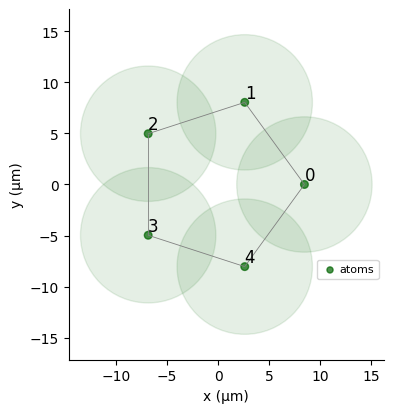

In [17]:
from pulser.devices import DigitalAnalogDevice

OMEGA = 1.0
rb = DigitalAnalogDevice.rydberg_blockade_radius(OMEGA)
edge_length = 0.75 * rb # edge_length < rb to create overlapping regions
reg = map_cyclic_graph_to_register(G5,edge_length)
draw_reg(reg,rb)

In [18]:
from pulser import Pulse
from pulser.waveforms import InterpolatedWaveform

delta_0 = -5  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 6000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

ADIABATIC_PULSE = Pulse(
    InterpolatedWaveform(T, [1e-9, OMEGA, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)

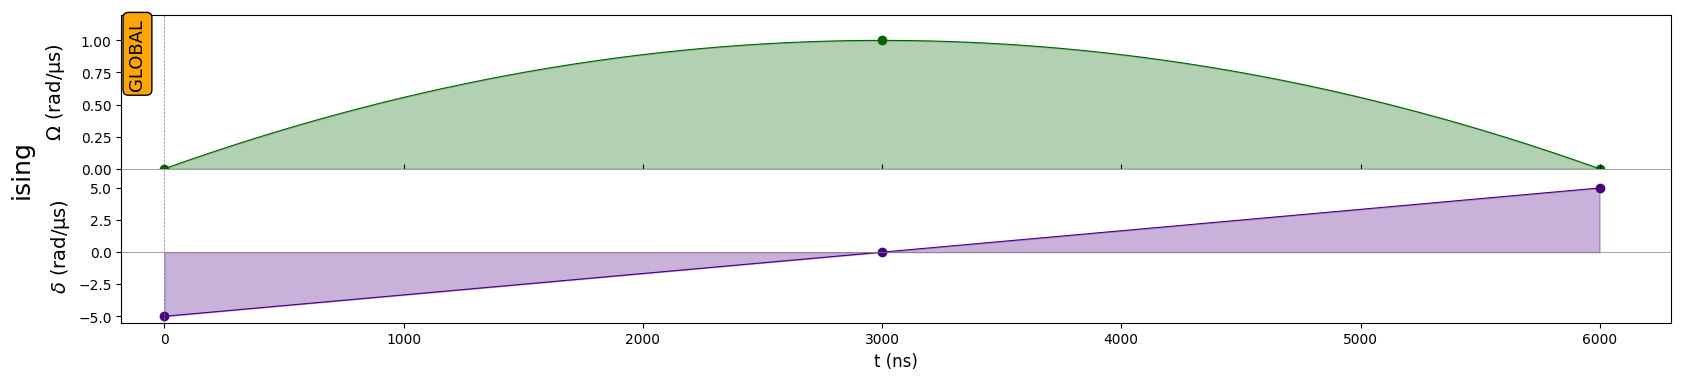

In [19]:
from pulser import Sequence

seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(ADIABATIC_PULSE, "ising")
seq.draw()

In [20]:
from pulser_simulation import QutipEmulator

def mis_adiabatic(graph):
  rb = DigitalAnalogDevice.rydberg_blockade_radius(OMEGA)
  edge_length = rb * 0.75 # edge_length < rb to create overlapping region
  reg = map_cyclic_graph_to_register(graph, edge_length)

  seq = Sequence(reg, DigitalAnalogDevice)
  seq.declare_channel("ising", "rydberg_global")
  seq.add(ADIABATIC_PULSE, "ising")

  simul = QutipEmulator.from_sequence(seq)
  results = simul.run()
  final = results.get_final_state()
  count_dict = results.sample_final_state()
  plot_distribution(count_dict)

  predicted_outcome = max(count_dict, key=lambda k: count_dict[k])

  nodes_to_color = [i for i,bit in enumerate(predicted_outcome) if bit == '1']
  draw_graph(graph, nodes_to_color)


/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


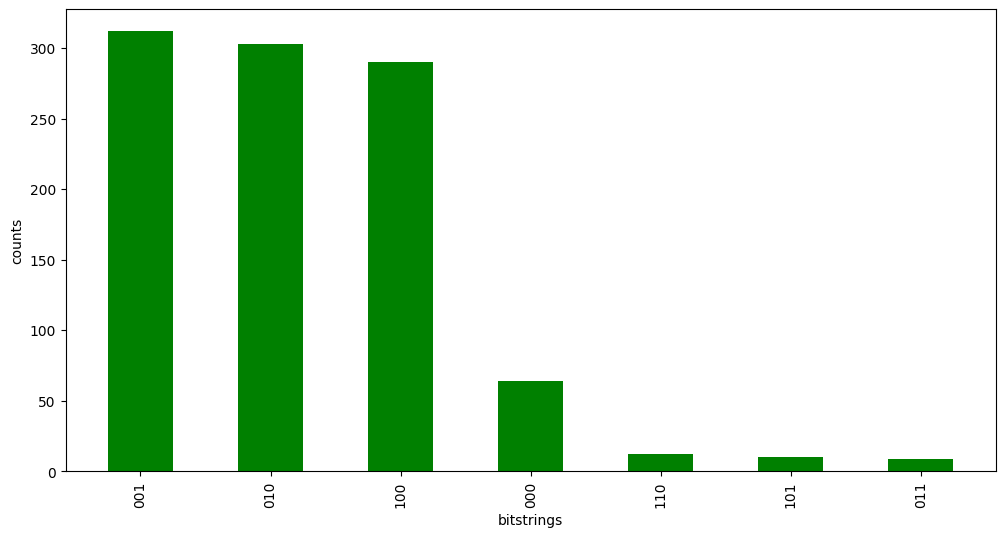

Cyclic graph with 3 nodes, has no maximal independent set


In [21]:
mis_adiabatic(G3)

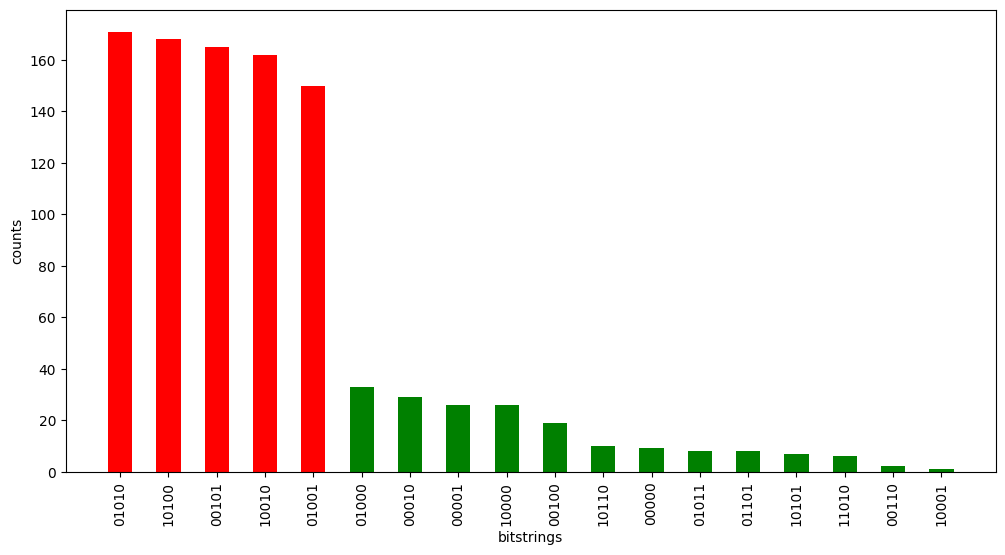

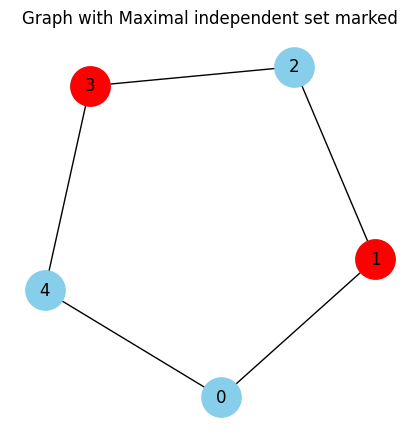

In [22]:
mis_adiabatic(G5)

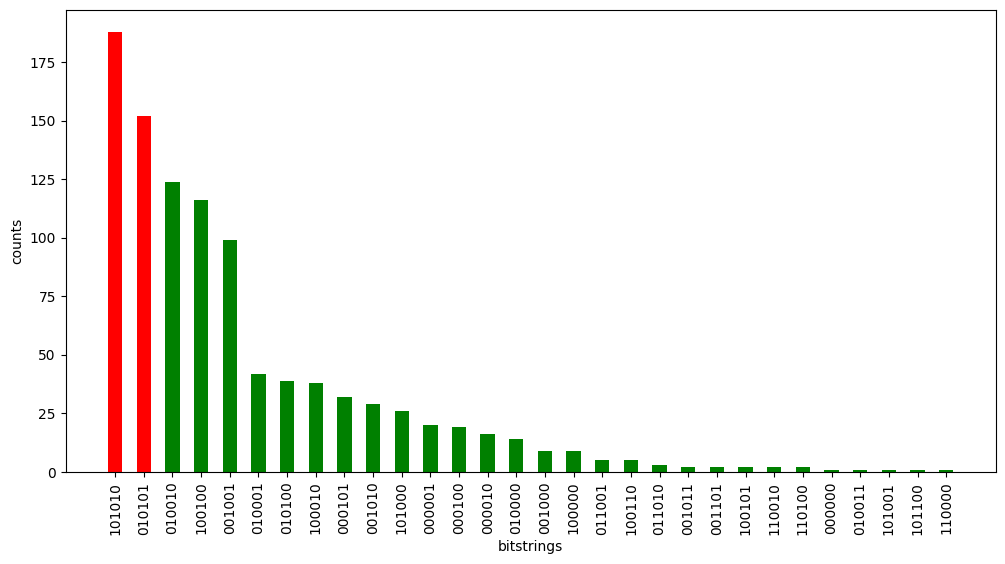

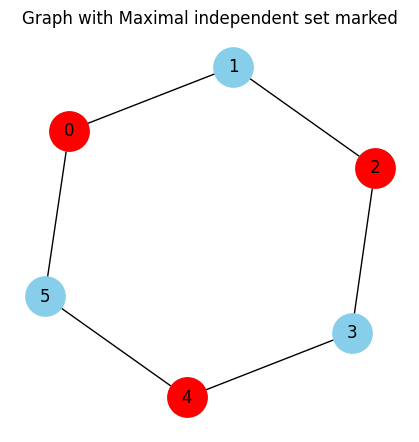

In [23]:
mis_adiabatic(G6)

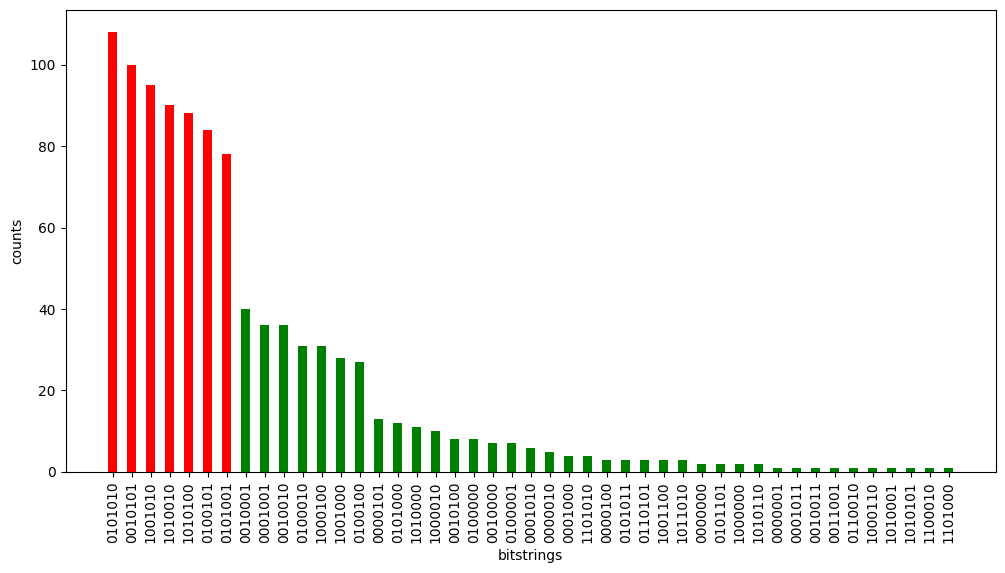

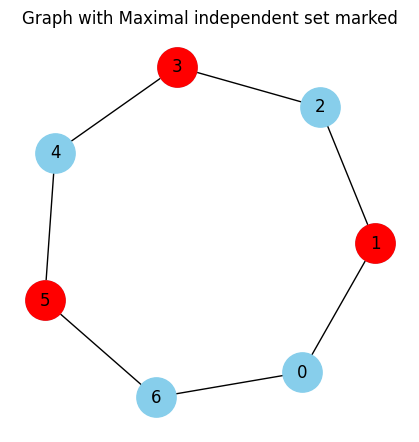

In [24]:
mis_adiabatic(G7)

### Analysis

* Both the gate-based approach and the adiabatic approach excel at finding solutions.
  * The gate-based approach tends to favor a single solution, providing it with a higher probability.
  * In contrast, the adiabatic approach distributes probabilities more evenly across multiple likely solutions.
* The adiabatic approach has faster processing times compared to the gate-based approach.
  * Primarily due to gate-based method approach using optimization loops.
  * In the adiabatic approach, the cost function is inherent within the analog system (rydberg atoms), leading to speedup.
* While the gate-based approach is versatile, capable of handling various graph types, the adiabatic approach requires graph modeling into unit disk graphs, potentially elongating the completion time.
  * In the case of cyclic graphs, the modeling was straightforward, resulting in speedup in the adiabatic solution.
* Notably, both algorithms identify a single node as the maximal independent set when such a set is not feasible.
